# 1. Data Exploration, Cleaning, and Feature Engineering

## 1.1 Data Description

In [1]:
# Load the pandas and numpy packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load essential datasets (CSV file) from Nile's platform, ensuring the correct encoding (Latin-1) to handle Portuguese-language characters properly.
customers = pd.read_csv("olist_customers_dataset.csv")
order_items = pd.read_csv("olist_order_items_dataset.csv")
payments = pd.read_csv("olist_order_payments_dataset.csv")
reviews = pd.read_csv("olist_order_reviews_dataset.csv", encoding='latin-1')
orders = pd.read_csv("olist_orders_dataset.csv")
products = pd.read_csv("olist_products_dataset.csv")
products_translation = pd.read_csv("product_category_name_translation.csv")

In [3]:
# Select vital columns based on predefined assumptions and unique identifiers in each dataset to facilitate accurate table joins.
orders = orders[['order_id', 'customer_id', 'order_status', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date']]
payments = payments[['order_id', 'payment_type']]
customers = customers[['customer_id', 'customer_unique_id', 'customer_state' ]]
reviews = reviews[['review_id', 'order_id', 'review_score']]
products = products[['product_id', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty']]
order_items = order_items[['order_id', 'order_item_id', 'product_id', 'price']]

## 1.2 Joining Tables

In [4]:
# Second, we combined imported datasets by particular keys 
combine1 = reviews.merge(orders, how='left', left_on='order_id', right_on='order_id')
combine2 = combine1.merge(payments, how='left', left_on='order_id', right_on='order_id')
combine3 = combine2.merge(customers, how='left', left_on='customer_id', right_on='customer_id')
combine4 = combine3.merge(order_items, how='left', left_on='order_id', right_on='order_id')
final_table = combine4.merge(products, how='left', left_on='product_id', right_on='product_id')

final_table['product_category_name_eng'] = final_table['product_category_name'].map(
    products_translation.set_index('product_category_name')['product_category_name_english'])

print(final_table.shape)

(107254, 19)


## 1.3 Exploratory Data Analysis (EDA)

### First of all, the proportion of review scores (dependent values of the predictive model) is critically important to affect the accuracy and future strategies of developing the model.

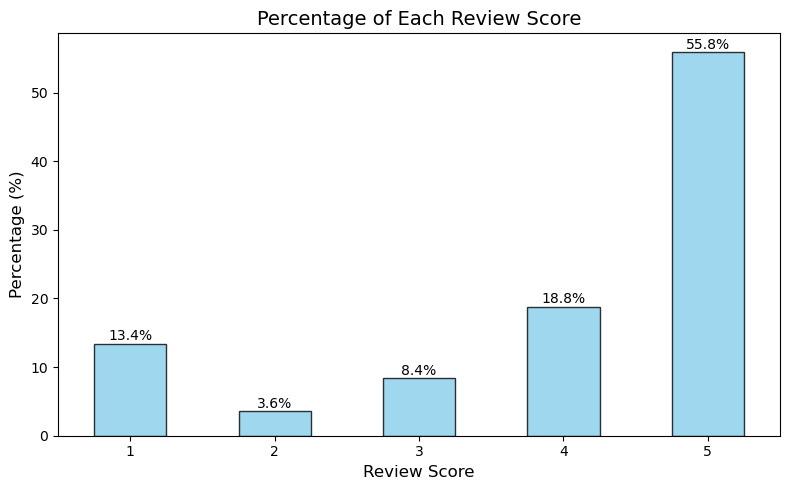

In [5]:
# Calculate percentage of each review score
review_percentage = final_table['review_score'].value_counts(normalize=True) * 100

# Plot a bar chart with percentage labels
plt.figure(figsize=(8, 5))
bars = review_percentage.sort_index().plot(kind='bar', alpha=0.8, color='skyblue', edgecolor='black')

# Add percentage labels on top of each bar
for bar, percentage in zip(bars.patches, review_percentage.sort_index()):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, 
             f'{percentage:.1f}%', ha='center', fontsize=10)

# Plot a bar chart
plt.title("Percentage of Each Review Score", fontsize=14)
plt.xlabel("Review Score", fontsize=12)
plt.ylabel("Percentage (%)", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle=' ', alpha=0.7)
plt.tight_layout()
plt.show()


### Additionally, depending on the order status, the distribution of review scores may be different and directly affect our model.

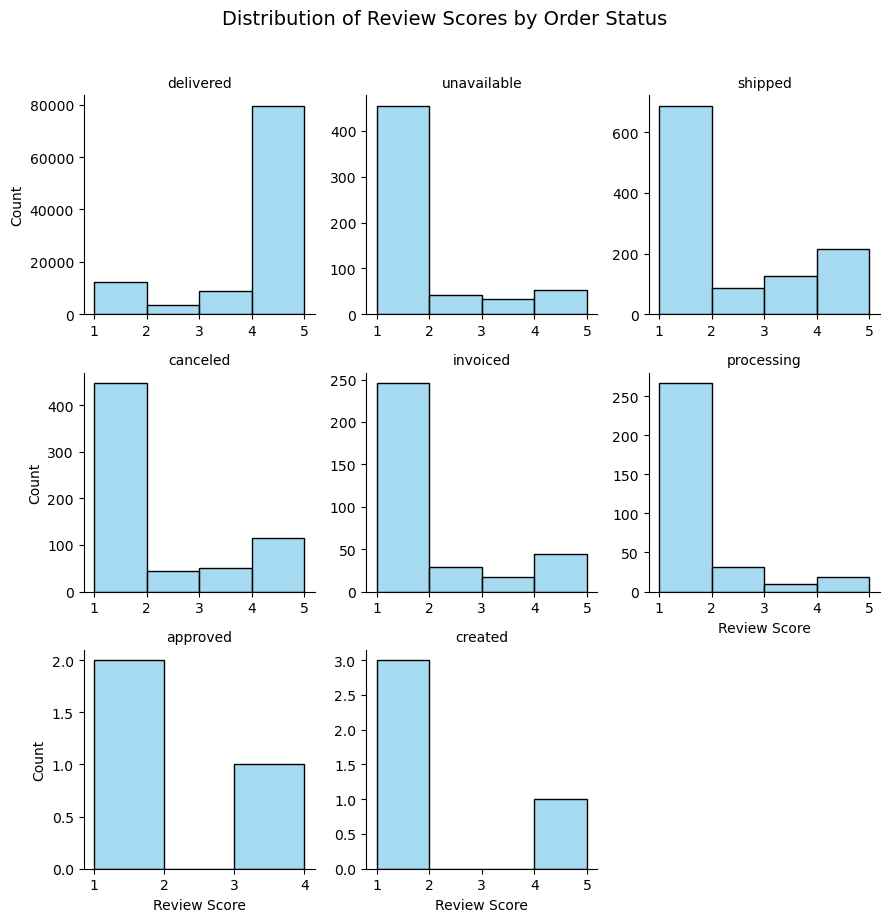

In [6]:
import warnings
warnings.filterwarnings("ignore")

# Filter for necessary columns
facet_data = final_table[['order_status', 'review_score']].dropna()

# Create a FacetGrid for the distribution of review scores by order status
g = sns.FacetGrid(facet_data, col="order_status", col_wrap=3, sharex=False, sharey=False)
g.map(sns.histplot, "review_score", kde=False, binwidth=1, color='skyblue', edgecolor='black')

# Adjust titles and layout
g.set_titles("{col_name}")
g.set_axis_labels("Review Score", "Count")
g.fig.suptitle("Distribution of Review Scores by Order Status", y=1.02, fontsize=14)
plt.tight_layout()
plt.show()


### Subsequently, exploring summary statistics of numeric columns can help us understand the dataset.

In [7]:
# Select columns of interest
columns_of_interest = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'price']
summary_stats = final_table[columns_of_interest].describe()

# Print out the result
print(summary_stats)

       product_name_lenght  product_description_lenght  product_photos_qty  \
count        104979.000000               104979.000000       104979.000000   
mean             48.770221                  785.578659            2.204431   
std              10.034715                  650.672657            1.715160   
min               5.000000                    4.000000            1.000000   
25%              42.000000                  347.000000            1.000000   
50%              52.000000                  600.000000            1.000000   
75%              57.000000                  985.000000            3.000000   
max              76.000000                 3992.000000           20.000000   

               price  
count  106507.000000  
mean      120.337782  
std       183.522158  
min         0.850000  
25%        39.900000  
50%        74.900000  
75%       134.000000  
max      6735.000000  


### Lastly, the number of categories in necessary categorical columns must be calculated. For the next section, feature engineering must deal with these categorical data.

In [8]:
# Create a DataFrame to display the unique category counts
categories_counts_df = pd.DataFrame({
    "Column": ["product_category_name", "payment_type", "customer_state"],
    "Number of Categories": [
        final_table['product_category_name'].nunique(),
        final_table['payment_type'].nunique(),
        final_table['customer_state'].nunique()
    ]
})

# Print out the result
print(categories_counts_df)

                  Column  Number of Categories
0  product_category_name                    73
1           payment_type                     5
2         customer_state                    27


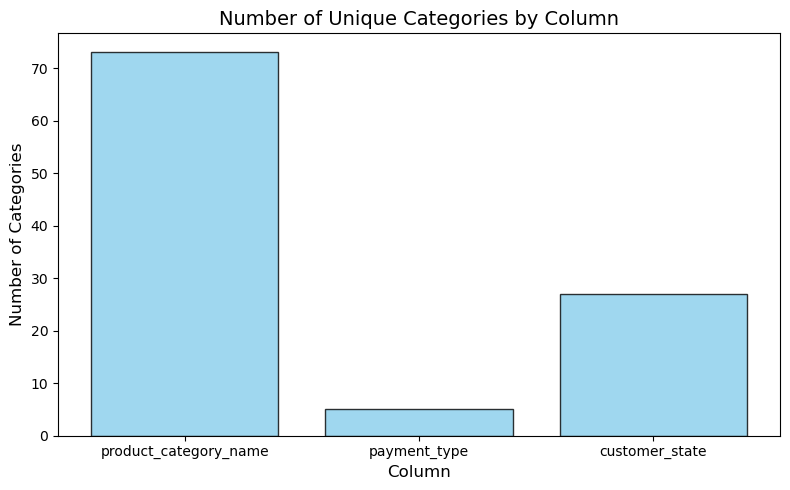

In [9]:
# Extract data for plotting
columns = categories_counts_df["Column"]
num_categories = categories_counts_df["Number of Categories"]

# Plot the data as a bar chart
plt.figure(figsize=(8, 5))
plt.bar(columns, num_categories, color='skyblue', edgecolor='black', alpha=0.8)
plt.title("Number of Unique Categories by Column", fontsize=14)
plt.xlabel("Column", fontsize=12)
plt.ylabel("Number of Categories", fontsize=12)
plt.xticks(fontsize=10)
plt.tight_layout()
plt.grid(axis='y', linestyle=' ', alpha=0.7)
plt.show()


## 1.4 Data Cleaning

### Finding and removing all missing values and duplicates is crucial to checking the data quality and ensuring the modelling process's effectiveness.

#### The initial step is identifying and removing all missing values to uphold data integrity.

In [10]:
# Identify the presence of missing values to ensure data completeness.
print(final_table.isnull().sum())

review_id                           0
order_id                            0
review_score                        0
customer_id                         0
order_status                        0
order_approved_at                 161
order_delivered_customer_date    3022
order_estimated_delivery_date       0
payment_type                        3
customer_unique_id                  0
customer_state                      0
order_item_id                     747
product_id                        747
price                             747
product_category_name            2275
product_name_lenght              2275
product_description_lenght       2275
product_photos_qty               2275
product_category_name_eng        2297
dtype: int64


In [11]:
# Understanding the reason and target is critical When finding around 3,000 rows missing in the order_delivered_customer_date.
# Therefore, printing out some rows of the missing rows means the majority of orders still need to be delivered.
print(final_table[final_table['order_delivered_customer_date'].isnull()]['order_status'].value_counts())
final_table[final_table['order_delivered_customer_date'].isnull()].head()

order_status
shipped        1112
canceled        650
unavailable     584
invoiced        336
processing      326
delivered         7
created           4
approved          3
Name: count, dtype: int64


,review_id,order_id,review_score,customer_id,order_status,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_type,customer_unique_id,customer_state,order_item_id,product_id,price,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name_eng
23,d5d01007883616401b65674911160c82,0010dedd556712d7bb69a19cb7bbd37a,1,3a92efdb6e6163dc1734d44f2f5f6d04,unavailable,2017-10-24 03:25:32,NaN,2017-11-03 00:00:00,boleto,a77550dd00887c5bb24100ccbd08cbe9,SP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
69,396eacbff771557619771e8d4b58ee77,002f19a65a2ddd70a090297872e6d64e,3,7fa80efb1ef15ca4104627910c29791c,shipped,2018-03-21 13:15:27,NaN,2018-04-16 00:00:00,voucher,205d5aa158338f2b733a07326aae8c87,BA,1.0,9eae06d51aaa383b2bed5547a19d581c,53.98,cama_mesa_banho,52.0,337.0,1.0,bed_bath_table
70,396eacbff771557619771e8d4b58ee77,002f19a65a2ddd70a090297872e6d64e,3,7fa80efb1ef15ca4104627910c29791c,shipped,2018-03-21 13:15:27,NaN,2018-04-16 00:00:00,voucher,205d5aa158338f2b733a07326aae8c87,BA,1.0,9eae06d51aaa383b2bed5547a19d581c,53.98,cama_mesa_banho,52.0,337.0,1.0,bed_bath_table
227,cea44be87d0e2370f1304b3805596e5d,00a500bc03bc4ec968e574c2553bed4b,2,3d2f26eab3f79dd1fe9977f615e70c2f,unavailable,2017-11-25 10:54:38,NaN,2018-01-08 00:00:00,credit_card,cd88b962adbc4b174353217f99dc6174,BA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
236,e92a1612d8dcd014217178bd28cc54b2,00a99c50fdff7e36262caba33821875a,5,7a399396442d5601cbedfbd0a3cf1da4,shipped,2018-08-17 16:35:18,NaN,2018-09-18 00:00:00,credit_card,60ec651482858c327c177cf9360cc0a2,BA,1.0,76d75f398634bf194ba99d7297e7d1fa,52.99,informatica_acessorios,59.0,1775.0,4.0,computers_accessories


In [12]:
# In addition, as mentioned in the EDA section, orders that could not be delivered might have a higher probability of receiving negative review scores(in the range of 1-3).
# Based on our guess, one severe problem is filtering out the orders except for those delivered.
final_table = final_table[final_table['order_status'] == 'delivered']

In [13]:
# Checking any missing value again
print(final_table.isnull().sum())

review_id                           0
order_id                            0
review_score                        0
customer_id                         0
order_status                        0
order_approved_at                  14
order_delivered_customer_date       7
order_estimated_delivery_date       0
payment_type                        3
customer_unique_id                  0
customer_state                      0
order_item_id                       0
product_id                          0
price                               0
product_category_name            1466
product_name_lenght              1466
product_description_lenght       1466
product_photos_qty               1466
product_category_name_eng        1486
dtype: int64


In [14]:
# Remove all rows containing missing values to ensure data integrity and consistency across all columns.
final_table = final_table[~final_table['product_category_name'].isnull()]
final_table = final_table[~final_table['product_category_name_eng'].isnull()]
final_table = final_table[~final_table['order_approved_at'].isnull()]
final_table = final_table[~final_table['order_delivered_customer_date'].isnull()]
final_table = final_table[~final_table['payment_type'].isnull()]


# Validate that all columns are free of missing values to maintain data quality and reliability.
print(final_table.isnull().sum())

review_id                        0
order_id                         0
review_score                     0
customer_id                      0
order_status                     0
order_approved_at                0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_type                     0
customer_unique_id               0
customer_state                   0
order_item_id                    0
product_id                       0
price                            0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_category_name_eng        0
dtype: int64


#### Next step: Verify the uniqueness of review ID, order ID, and product ID, and remove any duplicate entries to ensure data consistency.

In [15]:
# Finding rows that review ID, order approved date, product price, and even product category name are identical.
final_table[final_table.duplicated(subset=['review_id', 'order_id', 'customer_id', 'order_approved_at', 'product_id', 'price', 'product_category_name', 'order_item_id'], keep=False)].sort_values(by=['review_id', 'order_item_id'])

,review_id,order_id,review_score,customer_id,order_status,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_type,customer_unique_id,customer_state,order_item_id,product_id,price,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name_eng
12897,002dcef64fe5cdfa45ebdb04a4f682e0,1ebcf69fa275bb588691ece37ef82a30,5,19ad73c877b2ba253c68f626007cab97,delivered,2017-10-30 14:35:20,2017-11-08 18:12:56,2017-11-28 00:00:00,credit_card,c3f8dd46275f086dbdc3d03475311e93,PI,1.0,17c4bd4269902c84acc14c497f282ddb,299.99,telefonia,51.0,422.0,5.0,telephony
12899,002dcef64fe5cdfa45ebdb04a4f682e0,1ebcf69fa275bb588691ece37ef82a30,5,19ad73c877b2ba253c68f626007cab97,delivered,2017-10-30 14:35:20,2017-11-08 18:12:56,2017-11-28 00:00:00,credit_card,c3f8dd46275f086dbdc3d03475311e93,PI,1.0,17c4bd4269902c84acc14c497f282ddb,299.99,telefonia,51.0,422.0,5.0,telephony
12898,002dcef64fe5cdfa45ebdb04a4f682e0,1ebcf69fa275bb588691ece37ef82a30,5,19ad73c877b2ba253c68f626007cab97,delivered,2017-10-30 14:35:20,2017-11-08 18:12:56,2017-11-28 00:00:00,credit_card,c3f8dd46275f086dbdc3d03475311e93,PI,2.0,17c4bd4269902c84acc14c497f282ddb,299.99,telefonia,51.0,422.0,5.0,telephony
12900,002dcef64fe5cdfa45ebdb04a4f682e0,1ebcf69fa275bb588691ece37ef82a30,5,19ad73c877b2ba253c68f626007cab97,delivered,2017-10-30 14:35:20,2017-11-08 18:12:56,2017-11-28 00:00:00,credit_card,c3f8dd46275f086dbdc3d03475311e93,PI,2.0,17c4bd4269902c84acc14c497f282ddb,299.99,telefonia,51.0,422.0,5.0,telephony
21886,005827eb7eb6381f44bd1b76a702d14b,3453b206c6aec2e9dcb09d2cea15e7cb,5,cc12cc40c551d10e0122e34d2f0e1342,delivered,2017-08-10 10:50:21,2017-08-15 22:04:15,2017-08-25 00:00:00,credit_card,dcc7fb04fd4a19d3099e9f6e505ab08b,SP,1.0,f07dfd51b27ae763526ca43745920b7d,14.90,cama_mesa_banho,36.0,578.0,2.0,bed_bath_table
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27014,fffcfa6087cd3b651c68252342f13cb9,4069c489933782af79afcd3a0e4d693c,4,5d6ddc4e70e7d06e3b32e2ebd658de6c,delivered,2017-07-02 21:25:15,2017-07-13 19:19:52,2017-07-27 00:00:00,voucher,b0f3a98136fb0e22d808f855bd430970,RS,1.0,601a360bd2a916ecef0e88de72a6531a,129.99,cool_stuff,33.0,897.0,1.0,cool_stuff
27015,fffcfa6087cd3b651c68252342f13cb9,4069c489933782af79afcd3a0e4d693c,4,5d6ddc4e70e7d06e3b32e2ebd658de6c,delivered,2017-07-02 21:25:15,2017-07-13 19:19:52,2017-07-27 00:00:00,voucher,b0f3a98136fb0e22d808f855bd430970,RS,1.0,601a360bd2a916ecef0e88de72a6531a,129.99,cool_stuff,33.0,897.0,1.0,cool_stuff
27016,fffcfa6087cd3b651c68252342f13cb9,4069c489933782af79afcd3a0e4d693c,4,5d6ddc4e70e7d06e3b32e2ebd658de6c,delivered,2017-07-02 21:25:15,2017-07-13 19:19:52,2017-07-27 00:00:00,voucher,b0f3a98136fb0e22d808f855bd430970,RS,1.0,601a360bd2a916ecef0e88de72a6531a,129.99,cool_stuff,33.0,897.0,1.0,cool_stuff
27017,fffcfa6087cd3b651c68252342f13cb9,4069c489933782af79afcd3a0e4d693c,4,5d6ddc4e70e7d06e3b32e2ebd658de6c,delivered,2017-07-02 21:25:15,2017-07-13 19:19:52,2017-07-27 00:00:00,voucher,b0f3a98136fb0e22d808f855bd430970,RS,1.0,601a360bd2a916ecef0e88de72a6531a,129.99,cool_stuff,33.0,897.0,1.0,cool_stuff


In [16]:
# Then, filtering out those rows can ensure the quality and integrity of data.
final_table = final_table.drop_duplicates(subset=['review_id', 'order_id', 'order_approved_at', 'product_id', 'price'])

# At the end, check for any duplicates that remain in the dataset.
final_table[final_table.duplicated(subset=['review_id', 'order_id', 'customer_id', 'order_approved_at', 'product_id', 'price', 'product_category_name', 'order_item_id'], keep=False)].sort_values(by=['review_id', 'order_item_id'])

,review_id,order_id,review_score,customer_id,order_status,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_type,customer_unique_id,customer_state,order_item_id,product_id,price,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_category_name_eng


## 1.5 Feature Engineering

### 1.5.1 At the beginning, some additional columns are required according to our predefined assumptions.

#### Based on our assumption, the duration between the date of approving orders and the date of customer receiving orders might affect the customer's satisfaction and lead to higher or lower review scores.

In [17]:
# Firstly, we checked the type of order_approved_at and order_delivered_customer_date and found that those columns' types were object.
# Therefore, we need to change those types into datetime.

final_table.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89462 entries, 0 to 107253
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   review_id                      89462 non-null  object 
 1   order_id                       89462 non-null  object 
 2   review_score                   89462 non-null  int64  
 3   customer_id                    89462 non-null  object 
 4   order_status                   89462 non-null  object 
 5   order_approved_at              89462 non-null  object 
 6   order_delivered_customer_date  89462 non-null  object 
 7   order_estimated_delivery_date  89462 non-null  object 
 8   payment_type                   89462 non-null  object 
 9   customer_unique_id             89462 non-null  object 
 10  customer_state                 89462 non-null  object 
 11  order_item_id                  89462 non-null  float64
 12  product_id                     89462 non-null  obj

In [18]:
# As we mentioned above, we changed these columns' types into datetime.
final_table['order_delivered_customer_date'] = pd.to_datetime(final_table['order_delivered_customer_date'])
final_table['order_approved_at'] = pd.to_datetime(final_table['order_approved_at'])

# Then we subtract these two columns to calculate the difference between two dates
final_table['delivery_time'] = (final_table['order_delivered_customer_date'] - final_table['order_approved_at'])
final_table['delivery_time'] = final_table['delivery_time'].dt.days + final_table['delivery_time'].dt.seconds / (24 * 3600)

final_table = final_table[final_table['delivery_time'] > 0]

#### Another factor is whether orders arrived before the estimated delivery date provided by the system or seller. This column is also critical to customers' review scores.

In [19]:
# Add a new column to know whether orders arrived early or not
final_table['arrive_early_or_not'] = final_table['order_delivered_customer_date'] <= final_table['order_estimated_delivery_date']

# Turn boolean type into numeric type
final_table['arrive_early_or_not'] = np.where(final_table['arrive_early_or_not'] == True, 1, 0)

#### The third assumption is customers who have bought more times on this website are willing to give more positive scores on their orders. 

In [20]:
# This column counts the frequency at which a customer's unique ID appears.
id_counts = final_table['customer_unique_id'].value_counts()

# Assign the counts to each order
final_table['ID_count'] = final_table['customer_unique_id'].map(id_counts)

#### Finally, we assumed the higher total price of each order might potentially influence customers' emotions and subsequently affect their review scores.

In [21]:
# This column calculates the total price based on each order
total_price = final_table.groupby('order_id')['price'].sum()

# Assign the total price to each order
final_table['total_price'] = final_table['order_id'].map(total_price)

### 1.5.2 Due to the large number of unique categories in product category names, categorising them into 10 groups can help reduce the complexity of obtaining dummy variables.

In [22]:
# The dictionary of defining 71 categories into 10 groups

category_mapping = {
    "health_beauty": "Health and Beauty",
    "perfumery": "Health and Beauty",
    "diapers_and_hygiene": "Health and Beauty",
    "baby": "Health and Beauty",
        
    "computers_accessories": "Electronics and Technology",
    "telephony": "Electronics and Technology",
    "fixed_telephony": "Electronics and Technology",
    "tablets_printing_image": "Electronics and Technology",
    "audio": "Electronics and Technology",
    "electronics": "Electronics and Technology",
    "cine_photo": "Electronics and Technology",
    "computers": "Electronics and Technology",
    "home_appliances": "Electronics and Technology",
    "home_appliances_2": "Electronics and Technology",
    "air_conditioning": "Electronics and Technology",
    "small_appliances": "Electronics and Technology",
    "small_appliances_home_oven_and_coffee": "Electronics and Technology",
    "auto": "Electronics and Technology",
    
    "bed_bath_table": "Home and Furniture",
    "furniture_decor": "Home and Furniture",
    "housewares": "Home and Furniture",
    "garden_tools": "Home and Furniture",
    "furniture_mattress_and_upholstery": "Home and Furniture",
    "furniture_living_room": "Home and Furniture",
    "furniture_bedroom": "Home and Furniture",
    "home_confort": "Home and Furniture",
    "home_construction": "Home and Furniture",
    "home_comfort_2": "Home and Furniture",
    "kitchen_dining_laundry_garden_furniture": "Home and Furniture",
    "flowers": "Home and Furniture",
    
    "fashion_bags_accessories": "Fashion and Clothing",
    "fashion_shoes": "Fashion and Clothing",
    "fashion_male_clothing": "Fashion and Clothing",
    "fashion_female_clothing": "Fashion and Clothing",
    "fashion_underwear_beach": "Fashion and Clothing",
    "fashion_sport": "Fashion and Clothing",
    "fashion_childrens_clothes": "Fashion and Clothing",
    "watches_gifts": "Fashion and Clothing",
    
    "sports_leisure": "Sports and Leisure",
    "toys": "Sports and Leisure",
    "consoles_games": "Sports and Leisure",
    "party_supplies": "Sports and Leisure",
    
    "books_technical": "Books and Culture",
    "books_general_interest": "Books and Culture",
    "books_imported": "Books and Culture",
    "music": "Books and Culture",
    "cds_dvds_musicals": "Books and Culture",
    "dvds_blu_ray": "Books and Culture",
    "arts_and_craftmanship": "Books and Culture",
    "art": "Books and Culture",
    "musical_instruments": "Books and Culture",
    
    "food_drink": "Food and Beverages",
    "food": "Food and Beverages",
    "drinks": "Food and Beverages",
    "la_cuisine": "Food and Beverages",
    
    "stationery": "Office and Business",
    "office_furniture": "Office and Business",
    "industry_commerce_and_business": "Office and Business",
    "market_place": "Office and Business",
    "security_and_services": "Office and Business",
    
    "construction_tools_construction": "Construction and Tools",
    "construction_tools_garden": "Construction and Tools",
    "construction_tools_tools": "Construction and Tools",
    "construction_tools_lights": "Construction and Tools",
    "construction_tools_safety": "Construction and Tools",
    "agro_industry_and_commerce": "Construction and Tools",
    "signaling_and_security": "Construction and Tools",
    
    "pet_shop": "Pets and Special Items",
    "cool_stuff": "Pets and Special Items",
    "luggage_accessories": "Pets and Special Items",
    "christmas_supplies": "Pets and Special Items"

}

# Replace original 'product_category_name' column with new one!
final_table['product_category_name_10'] = final_table['product_category_name_eng'].map(category_mapping)

# Be aware there are still some missing value in 'product_category_name'
print(final_table.isnull().sum())

review_id                          0
order_id                           0
review_score                       0
customer_id                        0
order_status                       0
order_approved_at                  0
order_delivered_customer_date      0
order_estimated_delivery_date      0
payment_type                       0
customer_unique_id                 0
customer_state                     0
order_item_id                      0
product_id                         0
price                              0
product_category_name              0
product_name_lenght                0
product_description_lenght         0
product_photos_qty                 0
product_category_name_eng          0
delivery_time                      0
arrive_early_or_not                0
ID_count                           0
total_price                        0
product_category_name_10         313
dtype: int64


In [23]:
# Therefore, removing those missing rows to ensure the consistency of dataset.
final_table = final_table[~final_table['product_category_name_10'].isnull()]

# Lastly, there is no missing value.
print(final_table.isnull().sum())

review_id                        0
order_id                         0
review_score                     0
customer_id                      0
order_status                     0
order_approved_at                0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_type                     0
customer_unique_id               0
customer_state                   0
order_item_id                    0
product_id                       0
price                            0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_photos_qty               0
product_category_name_eng        0
delivery_time                    0
arrive_early_or_not              0
ID_count                         0
total_price                      0
product_category_name_10         0
dtype: int64


### 1.5.3 Because machine learning is not able to deal with categorical data, it is necessary to change those categorical columns into numeric ones.

In [24]:
# Dummy variables are the useful tool to deal with categorical data.
final_table = pd.get_dummies(final_table, columns=['payment_type'], prefix=['type_'], dtype=int, drop_first=True)
final_table = pd.get_dummies(final_table, columns=['customer_state'], prefix=['state_'], dtype=int, drop_first=True)
final_table = pd.get_dummies(final_table, columns=['product_category_name_10'], prefix=['category_'], dtype=int, drop_first=True)

In [25]:
# Subsequently, selecting columns that are vital for the development of modelling process.
categorical_columns = [col for col in final_table.columns if 'type' in col or 'state' in col or 'category_' in col]
manual_columns = ['review_score', 'price', 'total_price', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'arrive_early_or_not', 'delivery_time', 'ID_count']

specific_columns = manual_columns + categorical_columns

final_table = final_table[specific_columns]
final_table = final_table.drop(columns=['product_category_name', 'product_category_name_eng'])

# Checking the first few rows of the final table
final_table.head()


,review_score,price,total_price,product_name_lenght,product_description_lenght,product_photos_qty,arrive_early_or_not,delivery_time,ID_count,type__credit_card,...,state__TO,category__Construction and Tools,category__Electronics and Technology,category__Fashion and Clothing,category__Food and Beverages,category__Health and Beauty,category__Home and Furniture,category__Office and Business,category__Pets and Special Items,category__Sports and Leisure
0,5,58.90,58.90,58.0,598.0,4.0,1,7.582095,1,1,...,0,0,0,0,0,0,0,0,1,0
1,4,239.90,239.90,56.0,239.0,2.0,1,16.207766,2,1,...,0,0,0,0,0,0,0,0,1,0
2,5,199.00,199.00,59.0,695.0,2.0,1,7.938032,1,1,...,0,0,0,0,0,0,1,0,0,0
3,4,12.99,12.99,42.0,480.0,1.0,1,6.140521,1,1,...,0,0,0,0,0,1,0,0,0,0
4,5,199.90,199.90,59.0,409.0,1.0,1,25.105764,1,1,...,0,0,0,0,0,0,1,0,0,0


### 1.5.4 Data Standardisation

In [26]:
X_value = final_table.drop(['review_score'], axis = 1)
Y_value = np.where(final_table['review_score'] > 3, 1, 0)

print(X_value.shape)
print(Y_value.shape)

Y_value = np.ravel(Y_value)

(89096, 46)
(89096,)


In [27]:
from sklearn.preprocessing import MinMaxScaler

# create a MinMaxScaler object
scaler = MinMaxScaler()

# fit and transform the data
normal_data = scaler.fit_transform(X_value)

# recreate x_values using the scaled data and original feature names
X_value = pd.DataFrame(normal_data, columns=X_value.columns)
X_value.head()

,price,total_price,product_name_lenght,product_description_lenght,product_photos_qty,arrive_early_or_not,delivery_time,ID_count,type__credit_card,type__debit_card,...,state__TO,category__Construction and Tools,category__Electronics and Technology,category__Fashion and Clothing,category__Food and Beverages,category__Health and Beauty,category__Home and Furniture,category__Office and Business,category__Pets and Special Items,category__Sports and Leisure
0,0.008620,0.008620,0.746479,0.148947,0.157895,1.0,0.036329,0.000000,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.035498,0.035498,0.718310,0.058927,0.052632,1.0,0.077701,0.083333,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.029425,0.029425,0.760563,0.173270,0.052632,1.0,0.038037,0.000000,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.001803,0.001803,0.521127,0.119358,0.000000,1.0,0.029415,0.000000,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.029558,0.029558,0.760563,0.101555,0.000000,1.0,0.120378,0.000000,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [28]:
# split data into training and test
from sklearn.model_selection  import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_value, Y_value, test_size = 0.2, random_state=1234, stratify=Y_value)

# 2. Modelling and Evaluation

In [ ]:
# Import all necessary packages

from sklearn.ensemble import GradientBoostingClassifier as GBRT
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

## 2.1 Import selected models (Gradient Boosting, Extreme Gradient Boost, and Random Forest Classification)

In [ ]:
# Load gradient boosting and fit x train set and y train set into the model
gbrt = GBRT()
gbrt_model = gbrt.fit(X_train, Y_train)

# Load extreme gradient boost and fit x train set and y train set into the model
XGBC = XGBClassifier()
xgb_model = XGBC.fit(X_train, Y_train)

# Load random forest classification and fit x train set and y train set into the model
random_forest = RFC()
RF_model = random_forest.fit(X_train, Y_train)

### 2.1.1 Predict training data - using macro metrics and class 1 and 0 metrics to evaluate the performance of models

In [ ]:
models = [gbrt_model, xgb_model, RF_model]
names = ['Gradient Boosting', 'Extreme Gradient Boost', 'Random Forest']

for i in range(3):
  print(f"Model: {names[i]}")
  print("\n")

  # predict based on training data
  predict = models[i].predict(X_train)

  # Calculate macro metrics such as accuracy, precision, recall, and F1-score
  print(f'Accuracy: {accuracy_score(Y_train, predict)}')
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")


Model: Gradient Boosting


Accuracy: 0.8094730344014816
Macro Precision: 0.7857662384361414
Macro Recall: 0.5980680553412058
Macro F1-score: 0.6124560710339703


Model: Extreme Boosting


Accuracy: 0.8304899264829676
Macro Precision: 0.8280123845670659
Macro Recall: 0.6437620130436744
Macro F1-score: 0.6732791780791954


Model: Random Forest


Accuracy: 0.9990740221112295
Macro Precision: 0.9988439818691619
Macro Recall: 0.9984868075846178
Macro F1-score: 0.9986652582307112




In [ ]:
models = [gbrt_model, xgb_model, RF_model]
names = ['Gradient Boosting', 'Extreme Gradient Boost', 'Random Forest']

for i in range(3):
  print(f"Model: {names[i]}")
  print("\n")

  # predict based on training data
  predict = models[i].predict(X_train)

  # Calculate class 0 and 1 metrics such as accuracy, precision, recall, and F1-score
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict)
  print(f"Class 0 Precision: {precision[0]}")
  print(f"Class 0 Recall: {recall[0]}")
  print(f"Class 0 F1-score: {f1_score[0]}")
  print("\n")
  print(f"Class 1 Precision: {precision[1]}")
  print(f"Class 1 Recall: {recall[1]}")
  print(f"Class 1 F1-score: {f1_score[1]}")
  print("\n")


Model: Gradient Boosting


Class 0 Precision: 0.7586054721977052
Class 0 Recall: 0.21590052750565183
Class 0 F1-score: 0.3361360969886586


Class 1 Precision: 0.8129270046745775
Class 1 Recall: 0.9802355831767596
Class 1 F1-score: 0.8887760450792819


Model: Extreme Boosting


Class 0 Precision: 0.8250423011844331
Class 0 Recall: 0.3062044712383823
Class 0 F1-score: 0.44664285059998166


Class 1 Precision: 0.8309824679496987
Class 1 Recall: 0.9813195548489666
Class 1 F1-score: 0.8999155055584089


Model: Random Forest


Class 0 Precision: 0.99842846366608
Class 0 Recall: 0.9974252700326551
Class 0 F1-score: 0.9979266147273185


Class 1 Precision: 0.9992595000722438
Class 1 Recall: 0.9995483451365804
Class 1 F1-score: 0.999403901734104




### 2.1.1 Predict testing data - using macro metrics and class 1 and 0 metrics to evaluate the performance of models

In [ ]:
models = [gbrt_model, xgb_model, RF_model]
names = ['Gradient Boosting', 'Extreme Gradient Boost', 'Random Forest']

for i in range(3):
  print(f"Model: {names[i]}")
  print("\n")

  # predict based on testing data
  predict = models[i].predict(X_test)

  # Calculate macro metrics such as accuracy, precision, recall, and F1-score
  print(f'Accuracy: {accuracy_score(Y_test, predict)}')
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")


Model: Gradient Boosting


Accuracy: 0.8095959595959596
Macro Precision: 0.7869840708130318
Macro Recall: 0.597917361967503
Macro F1-score: 0.6122460561037648


Model: Extreme Boosting


Accuracy: 0.8129068462401796
Macro Precision: 0.772454955272321
Macro Recall: 0.6168687783337643
Macro F1-score: 0.6374927952371245


Model: Random Forest


Accuracy: 0.8048821548821549
Macro Precision: 0.7318196563729016
Macro Recall: 0.6210962346454568
Macro F1-score: 0.6408494063922435




In [ ]:
for i in range(3):
  print(f"Model: {names[i]}")

  # predict based on testing data
  predict = models[i].predict(X_test)

  # Calculate class 0 and 1 metrics such as accuracy, precision, recall, and F1-score
  print(f"Accuracy: {accuracy_score(Y_test, predict)}")
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict)
  print(f"Class 0 Precision: {precision[0]}")
  print(f"Class 0 Recall: {recall[0]}")
  print(f"Class 0 F1-score: {f1_score[0]}")
  print("\n")
  print(f"Class 1 Precision: {precision[1]}")
  print(f"Class 1 Recall: {recall[1]}")
  print(f"Class 1 F1-score: {f1_score[1]}")
  print("\n")

Model: Gradient Boosting
Accuracy: 0.8095959595959596
Class 0 Precision: 0.761101243339254
Class 0 Recall: 0.21527254458678724
Class 0 F1-score: 0.33561777951830823


Class 1 Precision: 0.8128668982868096
Class 1 Recall: 0.9805621793482188
Class 1 F1-score: 0.8888743326892214


Model: Extreme Boosting
Accuracy: 0.8129068462401796
Class 0 Precision: 0.7241857241857241
Class 0 Recall: 0.2624968600854057
Class 0 F1-score: 0.38532448377581124


Class 1 Precision: 0.820724186358918
Class 1 Recall: 0.971240696582123
Class 1 F1-score: 0.8896611066984379


Model: Random Forest
Accuracy: 0.8048821548821549
Class 0 Precision: 0.6403118040089086
Class 0 Recall: 0.28887214267771916
Class 0 F1-score: 0.39813051756967277


Class 1 Precision: 0.8233275087368946
Class 1 Recall: 0.9533203266131945
Class 1 F1-score: 0.8835682952148143




## 2.2 Tuning parameters to improve the performance of models

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# create a hyperparameter search function
def random_search(algo, hyperparameters, X_train, Y_train):
  # do the search using 5 folds/chunks
  clf = RandomizedSearchCV(algo, hyperparameters, cv=5, random_state=1111,
                          scoring='f1_macro', n_iter=20, refit=True)

  # pass the data to fit/train
  clf.fit(X_train, Y_train)
    
  return clf.best_params_

# Gradient Boosting
GBRT_tuned_parameters = {
    'learning_rate': uniform(loc=0.01, scale=0.99),
    'n_estimators': randint(100, 500), 
    'max_depth': randint(2, 7),  
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['friedman_mse', 'squared_error']
}

GBRT_best_params = random_search(gbrt, GBRT_tuned_parameters, X_train, Y_train)


# Extreme Gradient Boost
XGB_tuned_parameters = {
    'learning_rate': uniform(loc=0.01, scale=0.99),
    'min_split_loss': randint(1, 8),
    'max_depth': randint(2, 9),
    'subsample': uniform(loc=0.01, scale=0.99),
    'max_delta_step': randint(1, 9)
}

XGB_best_params = random_search(XGBC, XGB_tuned_parameters, X_train, Y_train)


# Random Forest
RF_tuned_parameters = {
    'n_estimators': randint(50, 100),  
    'criterion': ['gini', 'entropy'],  
    'max_depth': randint(3, 9),  
    'min_samples_split': randint(3, 9),  
    'min_samples_leaf': randint(1, 5),  
    'max_features': ['sqrt', 'log2', None]
}
    
RF_best_params = random_search(random_forest, RF_tuned_parameters, X_train, Y_train)


# Train the models
gbrt = GBRT(**GBRT_best_params)
gbrt_model = gbrt.fit(X_train, Y_train)
print(GBRT_best_params)

XGBC = XGBClassifier(**XGB_best_params)
xgb_model = XGBC.fit(X_train, Y_train)
print(XGB_best_params)

random_forest = RFC(**RF_best_params)
RF_model = random_forest.fit(X_train, Y_train)
print(RF_best_params)

{'criterion': 'squared_error', 'learning_rate': 0.48071214687785424, 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 491}
{'learning_rate': 0.9603676826913937, 'max_delta_step': 7, 'max_depth': 8, 'min_split_loss': 4, 'subsample': 0.8963863806597202}
{'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 7, 'n_estimators': 96}


### 2.2.1 Predict training data - using macro metrics and class 1 and 0 metrics to evaluate the performance of models

In [ ]:
# score the models
models = [gbrt_model, xgb_model, RF_model] # redo this or it uses the old models

for i in range(3):
  print(f"Model: {names[i]}")

  # predict based on training data
  predict = models[i].predict(X_train)

  # Calculate macro metrics such accuracy, precision, recall, and F1-score
  print(f"Accuracy: {accuracy_score(Y_train, predict)}")
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

Model: Gradient Boosting
Accuracy: 0.8579185139457882
Macro Precision: 0.8711371039761238
Macro Recall: 0.7007635978224214
Macro F1-score: 0.7410882959413666


Model: Extreme Boosting
Accuracy: 0.8274033335203995
Macro Precision: 0.7939666602935896
Macro Recall: 0.6535616392962685
Macro F1-score: 0.6823181931571158


Model: Random Forest
Accuracy: 0.8124052977159212
Macro Precision: 0.7927293158568305
Macro Recall: 0.604473914502617
Macro F1-score: 0.6214189660897631




In [ ]:
models = [gbrt_model, xgb_model, RF_model]
names = ['Gradient Boosting', 'Extreme Gradient Boost', 'Random Forest']

for i in range(3):
  print(f"Model: {names[i]}")
  print("\n")

  # predict based on training data
  predict = models[i].predict(X_train)

  # Calculate class 0 and 1 metrics such as accuracy, precision, recall, and F1-score
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_train, predict)
  print(f"Class 0 Precision: {precision[0]}")
  print(f"Class 0 Recall: {recall[0]}")
  print(f"Class 0 F1-score: {f1_score[0]}")
  print("\n")
  print(f"Class 1 Precision: {precision[1]}")
  print(f"Class 1 Recall: {recall[1]}")
  print(f"Class 1 F1-score: {f1_score[1]}")
  print("\n")


Model: Gradient Boosting


Class 0 Precision: 0.8878629733708016
Class 0 Recall: 0.4166666666666667
Class 0 F1-score: 0.5671667307774502


Class 1 Precision: 0.854411234581446
Class 1 Recall: 0.984860528978176
Class 1 F1-score: 0.915009861105283


Model: XGBoosting


Class 0 Precision: 0.7520879732739421
Class 0 Recall: 0.3392991710625471
Class 0 F1-score: 0.46763025791933527


Class 1 Precision: 0.8358453473132372
Class 1 Recall: 0.9678241075299899
Class 1 F1-score: 0.8970061283948964


Model: Random Forest


Class 0 Precision: 0.7700444256399408
Class 0 Recall: 0.2285857824667169
Class 0 F1-score: 0.352525301438187


Class 1 Precision: 0.8154142060737202
Class 1 Recall: 0.9803620465385171
Class 1 F1-score: 0.8903126307413393




### 2.2.2 Predict testing data - using macro metrics and class 1 and 0 metrics to evaluate the performance of models

In [ ]:
models = [gbrt_model, xgb_model, RF_model]
names = ['Gradient Boosting', 'Extreme Gradient Boost', 'Random Forest']

for i in range(3):
  print(f"Model: {names[i]}")
  print("\n")

  # predict based on testing data
  predict = models[i].predict(X_test)

  # Calculate macro metrics such as accuracy precision, recall, and F1-score
  print(f'Accuracy: {accuracy_score(Y_test, predict)}')
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")


Model: Gradient Boosting


Accuracy: 0.8041526374859708
Macro Precision: 0.7326727700820386
Macro Recall: 0.6157953400264088
Macro F1-score: 0.6346416133590194


Model: XGBoosting


Accuracy: 0.7991021324354658
Macro Precision: 0.7169529291639523
Macro Recall: 0.6105753902683095
Macro F1-score: 0.6276577962021932


Model: Random Forest


Accuracy: 0.8107182940516274
Macro Precision: 0.7876747303841469
Macro Recall: 0.6012344948934493
Macro F1-score: 0.6169018770462299




In [ ]:
for i in range(3):
  print(f"Model: {names[i]}")

  # predict based on testing data
  predict = models[i].predict(X_test)

  # Calculate class 0 and 1 metrics such as accuracy, precision, recall, and F1-score
  print(f"Accuracy: {accuracy_score(Y_test, predict)}")
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict)
  print(f"Class 0 Precision: {precision[0]}")
  print(f"Class 0 Recall: {recall[0]}")
  print(f"Class 0 F1-score: {f1_score[0]}")
  print("\n")
  print(f"Class 1 Precision: {precision[1]}")
  print(f"Class 1 Recall: {recall[1]}")
  print(f"Class 1 F1-score: {f1_score[1]}")
  print("\n")

Model: Gradient Boosting
Accuracy: 0.8041526374859708
Class 0 Precision: 0.6443268665490888
Class 0 Recall: 0.27530771163024365
Class 0 F1-score: 0.38577965505103834


Class 1 Precision: 0.8210186736149885
Class 1 Recall: 0.9562829684225739
Class 1 F1-score: 0.8835035716670004


Model: Extreme Boosting
Accuracy: 0.7991021324354658
Class 0 Precision: 0.614768174012593
Class 0 Recall: 0.26978146194423513
Class 0 F1-score: 0.37500000000000006


Class 1 Precision: 0.8191376843153114
Class 1 Recall: 0.9513693185923838
Class 1 F1-score: 0.8803155924043863


Model: Random Forest
Accuracy: 0.8107182940516274
Class 0 Precision: 0.761168384879725
Class 0 Recall: 0.22255714644561667
Class 0 F1-score: 0.34441205053449947


Class 1 Precision: 0.8141810758885687
Class 1 Recall: 0.9799118433412819
Class 1 F1-score: 0.8893917035579604




## 2.3 Plotting feature importance to decide the following modelling strategies.

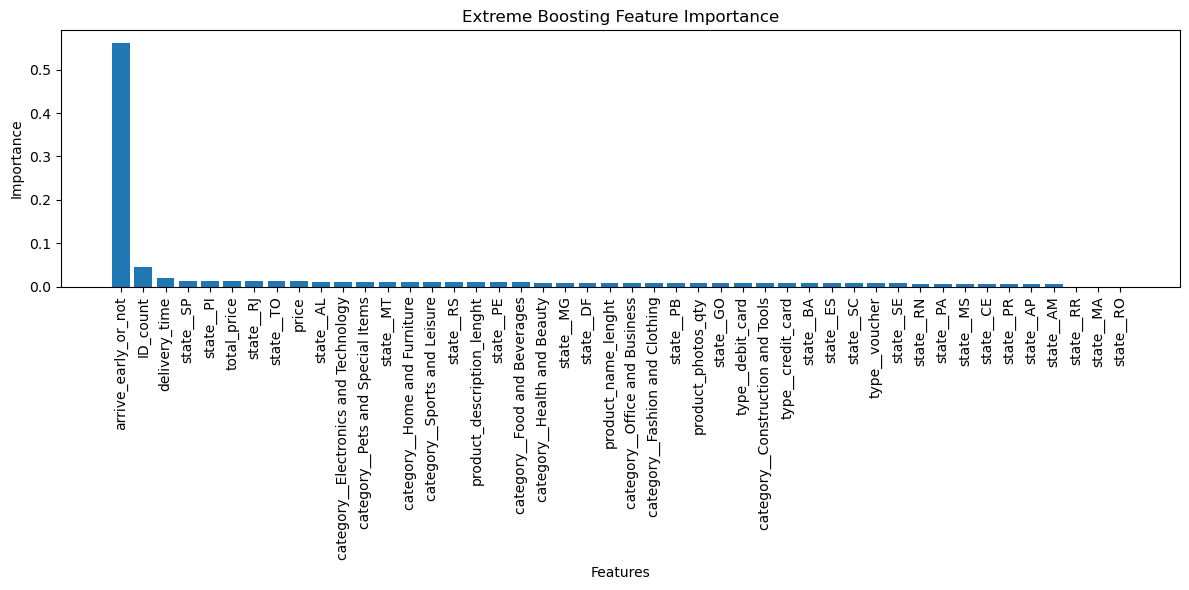

In [ ]:
# Access feature importances from the trained Gradient Boosting model
feature_importances = xgb_model.feature_importances_

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]  # Sort in descending order
sorted_importances = feature_importances[sorted_idx]
sorted_features = X_train.columns[sorted_idx]

# Plot feature importance
plt.figure(figsize=(12, 6))  # Set the figure size
plt.bar(range(len(sorted_importances)), sorted_importances, align="center")
plt.xticks(range(len(sorted_importances)), sorted_features, rotation=90)  # Rotate x-axis labels for readability
plt.title("Extreme Gradient Boost Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

## 2.4 Oversampling the minor group (Class 0) to fix the imbalance data issue

In [ ]:
# Using SMOTE method to sample on minorities
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=1111)
X_train_resampled, Y_train_resampled = smote.fit_resample(X_train, Y_train)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# create a hyperparameter search function for re-usability
def random_search(algo, hyperparameters, X_train, Y_train):
  # do the search using 5 folds/chunks
  clf = RandomizedSearchCV(algo, hyperparameters, cv=5, random_state=1111,
                          scoring='f1_macro', n_iter=20, refit=True)

  # pass the data to fit/train
  clf.fit(X_train, Y_train)
    
  return clf.best_params_

# Gradient Boosting
GBRT_tuned_parameters = {
    'learning_rate': uniform(loc=0.01, scale=0.99),
    'n_estimators': randint(100, 500), 
    'max_depth': randint(2, 7),  
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['friedman_mse', 'squared_error']
}

GBRT_best_params = random_search(gbrt, GBRT_tuned_parameters, X_train_resampled, Y_train_resampled)


# Extreme Gradient Boost
XGB_tuned_parameters = {
    'learning_rate': uniform(loc=0.01, scale=0.99),
    'min_split_loss': randint(1, 8),
    'max_depth': randint(2, 9),
    'subsample': uniform(loc=0.01, scale=0.99),
    'max_delta_step': randint(1, 9)
}

XGB_best_params = random_search(XGBC, XGB_tuned_parameters, X_train_resampled, Y_train_resampled)


# Random Forest
RF_tuned_parameters = {
    'n_estimators': randint(50, 100),  
    'criterion': ['gini', 'entropy'],  
    'max_depth': randint(3, 9),  
    'min_samples_split': randint(3, 9),  
    'min_samples_leaf': randint(1, 5),  
    'max_features': ['sqrt', 'log2', None]
}
    
RF_best_params = random_search(random_forest, RF_tuned_parameters, X_train_resampled, Y_train_resampled)


# Train the models
gbrt = GBRT(**GBRT_best_params)
gbrt_model = gbrt.fit(X_train_resampled, Y_train_resampled)
print(GBRT_best_params)

XGBC = XGBClassifier(**XGB_best_params)
xgb_model = XGBC.fit(X_train_resampled, Y_train_resampled)
print(XGB_best_params)

random_forest = RFC(**RF_best_params)
RF_model = random_forest.fit(X_train_resampled, Y_train_resampled)
print(RF_best_params)

KeyboardInterrupt: 

### 2.4.1 Predict testing data - using macro metrics and class 1 and 0 metrics to evaluate the performance of models

In [ ]:
models = [gbrt_model, xgb_model, RF_model]
names = ['Gradient Boosting', 'Extreme Gradient Boost', 'Random Forest']

for i in range(3):
  print(f"Model: {names[i]}")
  print("\n")

  # predict based on testing data
  predict = models[i].predict(X_test)

  # Calculate macro metrics such as accuracy precision, recall, and F1-score
  print(f'Accuracy: {accuracy_score(Y_test, predict)}')
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

In [ ]:
for i in range(3):
  print(f"Model: {names[i]}")

  # predict based on testing data
  predict = models[i].predict(X_test)

  # Calculate class 0 and 1 metrics such as precision, recall, and F1-score
  print(f"Accuracy: {accuracy_score(Y_test, predict)}")
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict)
  print(f"Class 0 Precision: {precision[0]}")
  print(f"Class 0 Recall: {recall[0]}")
  print(f"Class 0 F1-score: {f1_score[0]}")
  print("\n")
  print(f"Class 1 Precision: {precision[1]}")
  print(f"Class 1 Recall: {recall[1]}")
  print(f"Class 1 F1-score: {f1_score[1]}")
  print("\n")

## 2.5 Excluding the minor features to simplify the predictive model

In [57]:
# Removing customer state, payment type, and product category name (the minor features)

# Searching columns containing 'state', 'category', or 'type'
minor_column = [col for col in final_table.columns if "type" in col or "state" in col or "category" in col]
y_column = ['review_score']

drop_columns = minor_column + y_column

# For x value, the minor features will be removed
X_value = final_table.drop(columns=drop_columns)
Y_value = np.where(final_table['review_score'] > 3, 1, 0)

print(X_value.shape)
print(Y_value.shape)

Y_value = np.ravel(Y_value)

(89096, 8)
(89096,)


### 2.5.1 Fitting the data into selected models

In [ ]:
# Load gradient boosting and fit x train set and y train set into the model
gbrt_drop = GBRT()
gbrt_drop_model = gbrt_drop.fit(X_train, Y_train)

# Load extreme gradient boost and fit x train set and y train set into the model
XGBC_drop = XGBClassifier()
xgb_drop_model = XGBC_drop.fit(X_train, Y_train)

# Load random forest classification and fit x train set and y train set into the model
random_forest_drop = RFC()
RF_drop_model = random_forest_drop.fit(X_train, Y_train)

### 2.5.2 Hyperparameter for several unique branding

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# create a hyperparameter search function
def random_search(algo, hyperparameters, X_train, Y_train):
  # do the search using 5 folds/chunks
  clf = RandomizedSearchCV(algo, hyperparameters, cv=5, random_state=1111,
                          scoring='f1_macro', n_iter=20, refit=True)

  # pass the data to fit/train
  clf.fit(X_train, Y_train)
    
  return clf.best_params_

# Gradient Boosting
GBRT_tuned_parameters = {
    'learning_rate': uniform(loc=0.01, scale=0.99),
    'n_estimators': randint(100, 500), 
    'max_depth': randint(2, 7),  
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['friedman_mse', 'squared_error']
}

GBRT_best_params = random_search(gbrt_drop, GBRT_tuned_parameters, X_train, Y_train)


# Extreme Gradient Boost
XGB_tuned_parameters = {
    'learning_rate': uniform(loc=0.01, scale=0.99),
    'min_split_loss': randint(1, 8),
    'max_depth': randint(2, 9),
    'subsample': uniform(loc=0.01, scale=0.99),
    'max_delta_step': randint(1, 9)
}

XGB_best_params = random_search(XGBC_drop, XGB_tuned_parameters, X_train, Y_train)


# Random Forest
RF_tuned_parameters = {
    'n_estimators': randint(50, 100),  
    'criterion': ['gini', 'entropy'],  
    'max_depth': randint(3, 9),  
    'min_samples_split': randint(3, 9),  
    'min_samples_leaf': randint(1, 5),  
    'max_features': ['sqrt', 'log2', None]
}
    
RF_best_params = random_search(random_forest_drop, RF_tuned_parameters, X_train, Y_train)


# Train the models
gbrt_drop = GBRT(**GBRT_best_params)
gbrt_drop_model = gbrt_drop.fit(X_train, Y_train)
print(GBRT_best_params)

XGBC_drop = XGBClassifier(**XGB_best_params)
xgb_drop_model = XGBC_drop.fit(X_train, Y_train)
print(XGB_best_params)

random_forest_drop = RFC(**RF_best_params)
RF_drop_model = random_forest_drop.fit(X_train, Y_train)
print(RF_best_params)

### 2.5.3 Predict testing data - using macro metrics and class 1 and 0 metrics to evaluate the performance of models

In [ ]:
models = [gbrt_model, xgb_model, RF_model]
names = ['Gradient Boosting', 'Extreme Gradient Boost', 'Random Forest']

for i in range(3):
  print(f"Model: {names[i]}")
  print("\n")

  # predict based on testing data
  predict = models[i].predict(X_test)

  # Calculate macro metrics such as accuracy precision, recall, and F1-score
  print(f'Accuracy: {accuracy_score(Y_test, predict)}')
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict, average='macro')
  print(f"Macro Precision: {precision}")
  print(f"Macro Recall: {recall}")
  print(f"Macro F1-score: {f1_score}")
  print("\n")

In [ ]:
for i in range(3):
  print(f"Model: {names[i]}")

  # predict based on testing data
  predict = models[i].predict(X_test)

  # Calculate class 0 and 1 metrics such as precision, recall, and F1-score
  print(f"Accuracy: {accuracy_score(Y_test, predict)}")
  precision, recall, f1_score, _ = precision_recall_fscore_support(Y_test, predict)
  print(f"Class 0 Precision: {precision[0]}")
  print(f"Class 0 Recall: {recall[0]}")
  print(f"Class 0 F1-score: {f1_score[0]}")
  print("\n")
  print(f"Class 1 Precision: {precision[1]}")
  print(f"Class 1 Recall: {recall[1]}")
  print(f"Class 1 F1-score: {f1_score[1]}")
  print("\n")